<a href="https://colab.research.google.com/github/bhuvnk/EVA/blob/master/Assignment7/EVA_Assignment_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017)
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Input
from keras.layers.advanced_activations import ReLU, Softmax
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

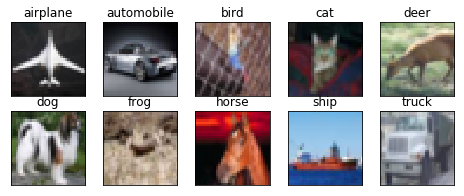

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

 #  7B final

 
 
 Layer|             Operation           |               input                       | Output
----------|-------------------------------------|------------------|-----------------------|
x1      |               Nothing             | Input(shape=(32, 32, 3,)) |   32   
x2      |               sep 5x5             | input = x1                            |   32   
x3      |              conv 5x5            | input = x2                            |    32  
x4      |              conv 5x5            | input = x3                            |   32   
x5      |              sep 5x5              |input = x4, x2                       |   32   
x6      |              MP 2x2               | input = x5, x2                      |   16
x7      |              sep 3x3               |input = x6                             |  16
x8      |              conv 5x5            | input = x7,x2,x5                   |  16
x9      |              sep 3x3              | input = x8, x4, x5, x7           |  16
x10    |              sep 5x5              | input = x9, x2, x4, x5, x7, x8 |  16
x11    |              MP 2x2               | input = x10, x2, x5, x7, x9  |  8
x12    |             conv 5x5             |  input = x11, x8                   |  8
x13    |             sep 5x5               | input = x12, x3, x5, x9        |  8
x14    |              conv 3x3            | input = x13, x3, x4, x7, x12  |  8
x15    |              sep 5x5               |input = x14, x2, x4, x5, x7, x9, x13  |  8
x16    |             1x1 reduce ch_# | input = x15, x5, x9, x13 |  8

In [0]:
from keras.models import Model
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Input, Lambda
from keras.layers.advanced_activations import ReLU, Softmax
from keras.layers.normalization import BatchNormalization

In [0]:
#When size difference is twice
def space_to_depth_2(x):
    return tf.space_to_depth(x, block_size=2)
  
#When size difference is 4 times
def space_to_depth_4(x):
    return tf.space_to_depth(x, block_size=4)

In [9]:
############################################
#### Block1
############################################

# x1 = Input
x1 = Input(shape=(32, 32, 3,), name = 'x1')

#x2 // sep 5x5 // input = x1  // 32
x2 = SeparableConv2D(16, (5,5), padding='same', use_bias=False, name='x2')(x1)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)

# x3 // conv 5x5 // input = x2  //32
x3 = Conv2D(32, (5,5), padding='same', use_bias=False, name='x3', kernel_regularizer=regularizers.l2(0.01))(x2)
x3 = BatchNormalization()(x3)
x3 = ReLU()(x3)
x3 = Dropout(0.2)(x3)

# x4 // conv 5x5 // input = x3   //32
x4 = Conv2D(64, (5,5), padding='same', use_bias=False, name='x4', kernel_regularizer=regularizers.l2(0.01))(x3)
x4 = BatchNormalization()(x4)
x4 = ReLU()(x4)
x4 = Dropout(0.2)(x4)


# x5 // sep 5x5 // input = x4, x2  //32
x4_x2_ = Concatenate(axis=-1)([x4,x2])
x4_x2_ = Conv2D(64, (1,1), padding='same', use_bias=False)(x4_x2_)

x5 = SeparableConv2D(128, (5,5), padding='same', use_bias=False, name = 'x5', kernel_regularizer=regularizers.l2(0.01))(x4_x2_)
x5 = BatchNormalization()(x5)
x5 = ReLU()(x5)
x5 = Dropout(0.2)(x5)

########################
### Transition1
########################
# x6 // MP 2x2 // input = x5, x2  //16
x5_x2_ = Concatenate(axis=-1)([x5,x2])
x5_x2_ = Conv2D(16, (1,1), padding='same', use_bias=False)(x5_x2_)

x6 = MaxPooling2D(pool_size=(2, 2), name = 'x6')(x5_x2_)
x6 = Dropout(0.2)(x6)

############################################
#### Block2
############################################
### Space to dept conversion from Block1 to Block2; block_size=2
x2_2 = Lambda(space_to_depth_2, name= 'x2_2')(x2)
x3_2 = Lambda(space_to_depth_2, name= 'x3_2')(x3)  # we don't need this one here
x4_2 = Lambda(space_to_depth_2, name= 'x4_2')(x4)
x5_2 = Lambda(space_to_depth_2, name= 'x5_2')(x5)

# X7 // sep 3x3 // input = x6   // 16
x7 = SeparableConv2D(32, (3,3), padding='same', use_bias=False, name='x7')(x6)
x7 = BatchNormalization()(x7)
x7 = ReLU()(x7)
x7 = Dropout(0.2)(x7)

# X8 // conv 5x5 // input = x7,x2,x5  //16
x7_x5_x2_ = Concatenate(axis=-1)([x7, x2_2, x5_2])
x7_x5_x2_ = Conv2D(32, (1,1), padding='same', use_bias=False)(x7_x5_x2_)

x8 = Conv2D(64, (5,5), padding='same', use_bias=False, name='x8')(x7_x5_x2_)
x8 = BatchNormalization()(x8)
x8 = ReLU()(x8)
x8 = Dropout(0.2)(x8)

# x9 // sep 3x3 // input = x8, x4, x5, x7  // 16
x8_x7_x5_x4_ = Concatenate(axis=-1)([x8, x4_2, x5_2, x7])
x8_x7_x5_x4_ = Conv2D(64, (1,1), padding='same', use_bias=False)(x8_x7_x5_x4_)

x9 = SeparableConv2D(128, (3,3), padding='same', use_bias=False, name='x9')(x8_x7_x5_x4_)
x9 = BatchNormalization()(x9)
x9 = ReLU()(x9)
x9 = Dropout(0.2)(x9)

# x10 // sep 5x5 // input = x9, x2, x4, x5, x7, x8 // 16
x9_x8_x7_x5_x4_x2_ = Concatenate(axis=-1)([x9, x2_2, x4_2, x5_2, x7, x8])
x9_x8_x7_x5_x4_x2_ = Conv2D(128, (1,1), padding='same', use_bias=False)(x9_x8_x7_x5_x4_x2_)

x10 = SeparableConv2D(256, (5,5), padding='same', use_bias=False, name='x10')(x9_x8_x7_x5_x4_x2_)
x10 = BatchNormalization()(x10)
x10 = ReLU()(x10)
x10 = Dropout(0.2)(x10)

########################
### Transition2
########################
# x11 // MP 2x2 // input = x10, x2, x5, x7, x9  //8
x10_x9_x7_x5_x2_ = Concatenate(axis=-1)([x10, x2_2, x5_2, x7, x9])
x10_x9_x7_x5_x2_ = Conv2D(32, (1,1), padding='same', use_bias=False)(x10_x9_x7_x5_x2_)


x11 = MaxPooling2D(pool_size=(2, 2), name='x11')(x10_x9_x7_x5_x2_)
x11 = Dropout(0.25)(x11)

############################################
#### Block3
############################################
### Space to dept conversion from Block1 to Block3; block_size=4
x2_4 = Lambda(space_to_depth_4, name='x2_4')(x2)
x3_4 = Lambda(space_to_depth_4, name='x3_4')(x3)  # we don't need this one here
x4_4 = Lambda(space_to_depth_4, name='x4_4')(x4)
x5_4 = Lambda(space_to_depth_4, name='x5_4')(x5)

### Space to dept conversion from Block2 to Block4; block_size=2
x7_2 = Lambda(space_to_depth_2, name='x7_2')(x7)
x8_2 = Lambda(space_to_depth_2, name='x8_2')(x8)  # we don't need this one here
x9_2 = Lambda(space_to_depth_2, name='x9_2')(x9)
x10_2 = Lambda(space_to_depth_2, name='x10_2')(x10)


# x12 // conv 5x5 // input = x11, x8 // 8
x11_x8_ = Concatenate(axis=-1)([x11, x8_2])
x11_x8_ = Conv2D(32, (1,1), padding='same', use_bias=False)(x11_x8_)

x12 = Conv2D(64, (5,5),  padding='same', use_bias=False, name='x12')(x11_x8_)
x12 = BatchNormalization()(x12)
x12 = ReLU()(x12)
x12 = Dropout(0.3)(x12)

# x13 // sep 5x5 // input = x12, x3, x5, x9 // 8
x12_x9_x5_x3_ = Concatenate(axis=-1)([x12, x3_4, x5_4, x9_2])
x12_x9_x5_x3_ = Conv2D(64, (1,1), padding='same', use_bias=False)(x12_x9_x5_x3_)

x13 = SeparableConv2D(128, (5,5), padding='same', use_bias=False, name='x13')(x12_x9_x5_x3_)
x13 = BatchNormalization()(x13)
x13 = ReLU()(x13)
x13 = Dropout(0.3)(x13)

# x14 // conv 3x3 // input = x13, x3, x4, x7, x12 // 8
x13_x12_x7_x4_x3_ = Concatenate(axis=-1)([x13, x3_4, x4_4, x7_2, x12])
x13_x12_x7_x4_x3_ = Conv2D(128, (1,1), padding='same', use_bias=False)(x13_x12_x7_x4_x3_)

x14 = Conv2D(256, (3,3),  padding='same', use_bias=False, name='x14')(x13_x12_x7_x4_x3_)
x14 = BatchNormalization()(x14)
x14 = ReLU()(x14)
x14 = Dropout(0.3)(x14)

# x15 // sep 5x5 // input = x14, x2, x4, x5, x7, x9, x13  // 8
x14_x13_x9_x7_x5_x4_x2_ = Concatenate(axis=-1)([x14, x2_4, x4_4, x5_4, x7_2, x9_2, x13])
x14_x13_x9_x7_x5_x4_x2_ = Conv2D(256, (1,1), padding='same', use_bias=False)(x14_x13_x9_x7_x5_x4_x2_)

x15 = SeparableConv2D(512, (5,5), padding='same', use_bias=False, name='x15')(x14_x13_x9_x7_x5_x4_x2_)
x15 = BatchNormalization()(x15)
x15 = ReLU()(x15)

# x16 // conv 1x1 to reduce channel size // input = x15, x5, x9, x13  // 1
x16 = Conv2D(10, (1,1), name = 'x16_to_numclass', use_bias=False)(Concatenate(axis=-1)([x15, x5_4, x9_2, x13]))
avg_pool = GlobalAveragePooling2D(name='x16_gap')(x16)
output = Softmax(name='x16_softmax')(avg_pool)

model = Model(inputs=[x1], outputs=[output])

model.summary()

W0622 16:55:22.664305 140710580082560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 16:55:22.680706 140710580082560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0622 16:55:22.698632 140710580082560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 16:55:22.715078 140710580082560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0622 16:55:22.715931 1407105800

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x1 (InputLayer)                 (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
x2 (SeparableConv2D)            (None, 32, 32, 16)   123         x1[0][0]                         
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          x2[0][0]                         
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
x3 (Conv2D

W0622 16:55:24.742400 140710580082560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  from ipykernel imp

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 74s 190ms/step - loss: 1.6194 - acc: 0.4902 - val_loss: 2.4436 - val_acc: 0.4173
Epoch 2/100
390/390 [==============================] - 68s 175ms/step - loss: 1.1064 - acc: 0.6448 - val_loss: 1.7397 - val_acc: 0.5041
Epoch 3/100
390/390 [==============================] - 67s 172ms/step - loss: 0.9192 - acc: 0.7083 - val_loss: 1.6575 - val_acc: 0.5476
Epoch 4/100
390/390 [==============================] - 67s 172ms/step - loss: 0.8196 - acc: 0.7437 - val_loss: 0.8742 - val_acc: 0.7254
Epoch 5/100
390/390 [==============================] - 67s 172ms/step - loss: 0.7403 - acc: 0.7719 - val_loss: 1.0863 - val_acc: 0.6694
Epoch 6/100
390/390 [==============================] - 67s 172ms/step - loss: 0.6746 - acc: 0.7934 - val_loss: 0.8965 - val_acc: 0.7224
Epoch 7/100
390/390 [==============================] - 67s 172ms/step - loss: 0.6337 - acc: 0.8093 - val_loss: 1.2764 - val_acc: 0.6306
Epoch 8/100
390/390 [==============================] - 67s 1

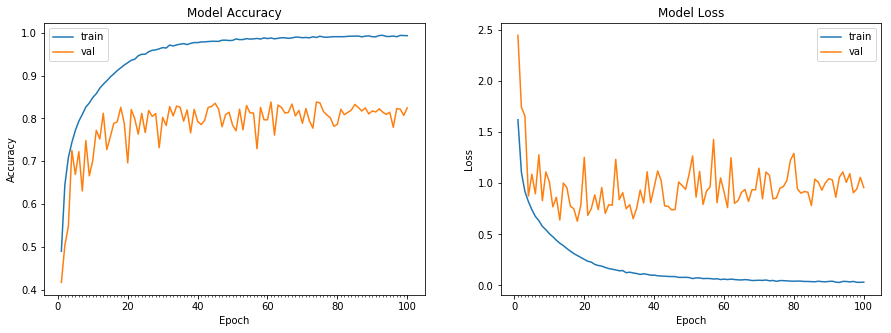

Accuracy on test data is: 82.47


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))